In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
drugbank_input = Chem.SDMolSupplier('../data/drugbank.sdf')
drugbank = [m for m in drugbank_input if m]

# Structural keys, MACCS
We already know how to do a simple substructure search.

But we can also describe, categorize and compare structures based on what substructures they contain.

The most straightforward way to do this is a structural key - a predefined set of structural patterns.

http://www.daylight.com/dayhtml/doc/theory/theory.finger.html

Let's make our own structural key!

## Custom structural key
a 7-bit key telling if the structure:
1. has a COO group
2. has a benzene core
3. has a nitrogen atom
4. has some halogen atom
5. has a triple bond
6. has aliphatic carbon
7. has sulphur in it

In [15]:
# defining the key substructures
patterns = {
    'coo': Chem.MolFromSmarts('C(=O)O'),
    'benzene': Chem.MolFromSmarts('c1ccccc1'),
    'n': Chem.MolFromSmarts('[#7]'), # N is for aliphatic, n for aromatic, #7 (atom. number 7) is for both
    'halogen': Chem.MolFromSmarts('[F,Cl,Br,I]'),
    'triple_bond': Chem.MolFromSmarts('*#*'),
    'aliphatic_c': Chem.MolFromSmarts('C'),
    's': Chem.MolFromSmarts('[#16]'),
}

patternorder = ('coo', 'benzene', 'n', 'halogen', 'triple_bond', 'aliphatic_c', 's')

def customkey(mol):
    return tuple([mol.HasSubstructMatch(patterns[patternname]) for patternname in patternorder])

Let's test our new great structural key!

In [21]:
customkey(drugbank[666])

(True, True, True, False, False, True, False)

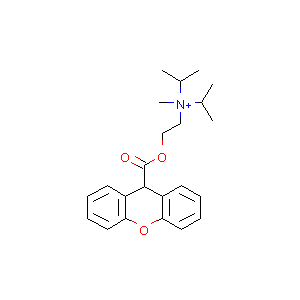

In [22]:
Draw.MolToImage(drugbank[666])

COO is there, benzene core too, as well as nitrogen.

No triple bonds or halogens, aliphatic carbons are present, but sulphur isn't.

The computed structural key seems correct. Let's try one more?

In [25]:
customkey(drugbank[33])

(False, False, True, False, False, True, False)

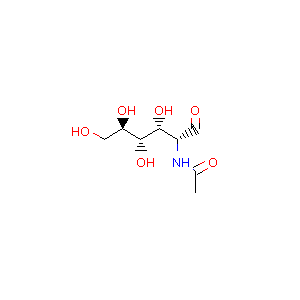

In [26]:
Draw.MolToImage(drugbank[33])

... seems about right.

Let's calculate our custom keys for the entire DrugBank database:

In [28]:
drugbank_fps = [customkey(mol) for mol in drugbank]
len(drugbank), len(drugbank_fps) # same length

(7110, 7110)

Is there any compound in Drugbank that contains all the patterns in our fingerprints?

In [30]:
all_pattern_compounds = [m for m, fp in zip(drugbank, drugbank_fps) if all(fp)]
len(all_pattern_compounds)

3

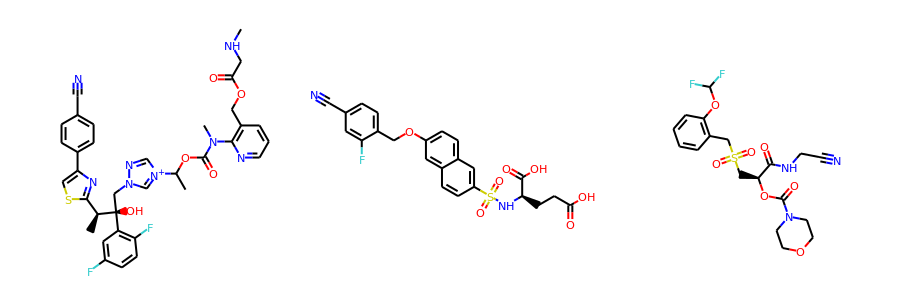

In [35]:
Draw.MolsToGridImage(all_pattern_compounds, subImgSize=(300, 300))

This way, we can define any structural key tailored for our particular needs or problems. However, making a new structural key means that
1. it often takes a lot of work
2. nobody else will probably use it
3. is often just not necessary

There are some predefined keys:

## Predefined keys, MACCS
http://rdkit.org/Python_Docs/rdkit.Chem.MACCSkeys-pysrc.html

In [45]:
from rdkit.Chem import MACCSkeys
maccs_fps = [MACCSkeys.GenMACCSKeys(mol) for mol in drugbank]

RDkit represents fingerprints as its own datatype with additional functinality, much like mol for molecules:

In [46]:
maccs_fps[0]

In [51]:
list(maccs_fps[33].GetOnBits()) # a convenient way to get the bits that were set

[53,
 54,
 72,
 82,
 89,
 90,
 91,
 92,
 95,
 97,
 104,
 109,
 110,
 117,
 131,
 132,
 136,
 139,
 140,
 146,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 164]

# Similarity
So, we can now search for molecules with specific substructures, but how can we compare them? Or, even better, how do we quantify their similarity?

Probably the most used method to compare binary vectors (structural keys, fingerprints...) is the Tanimoto similarity, aka Jaccard index:
https://en.wikipedia.org/wiki/Jaccard_index

let's implement it on our amazing fingerprint:

In [56]:
def tanimoto_similarity(fp1, fp2):
    fp1_on_bits = set([i for i, bit in enumerate(fp1) if bit]) # indices of True values
    fp2_on_bits = set([i for i, bit in enumerate(fp2) if bit]) # indices of True values
    all_bits = fp1_on_bits.union(fp2_on_bits)
    shared_bits = fp1_on_bits.intersection(fp2_on_bits)
    if not all_bits:
        return 0 # avoid division by zero for empty fingerprint
    else:
        return len(shared_bits) / len(all_bits)

let's test out our similarity metric implementation:

In [57]:
tanimoto_similarity((True, True, False, False), (True, True, False, False))

1.0

In [58]:
tanimoto_similarity((True, True, False, False), (False, False, False, False))

0.0

In [59]:
tanimoto_similarity((True, True, False, False), (False, False, True, False))

0.0

In [60]:
tanimoto_similarity((True, True, False, False), (False, True, False, False))

0.5

In [61]:
tanimoto_similarity((True, True, False, False), (False, True, True, True))

0.25

... seems legit. Now, let's try similarity searching drugbank with a new query structure:

In [64]:
salicylica = Chem.MolFromSmiles("c1ccc(c(c1)C(=O)O)O")
salicylica_key = customkey(salicylica)
salicylica_key

(True, True, False, False, False, True, False)

In [66]:
salicylica_similarities = [tanimoto_similarity(salicylica_key, mol_fp) for mol_fp in drugbank_fps]
len(salicylica_similarities), min(salicylica_similarities), max(salicylica_similarities)

(7110, 0.0, 1.0)

In [69]:
perfect_match_indexes = [i for i, similarity in enumerate(salicylica_similarities) if similarity == 1]
len(perfect_match_indexes)

148

Some examples with the perfect key match:

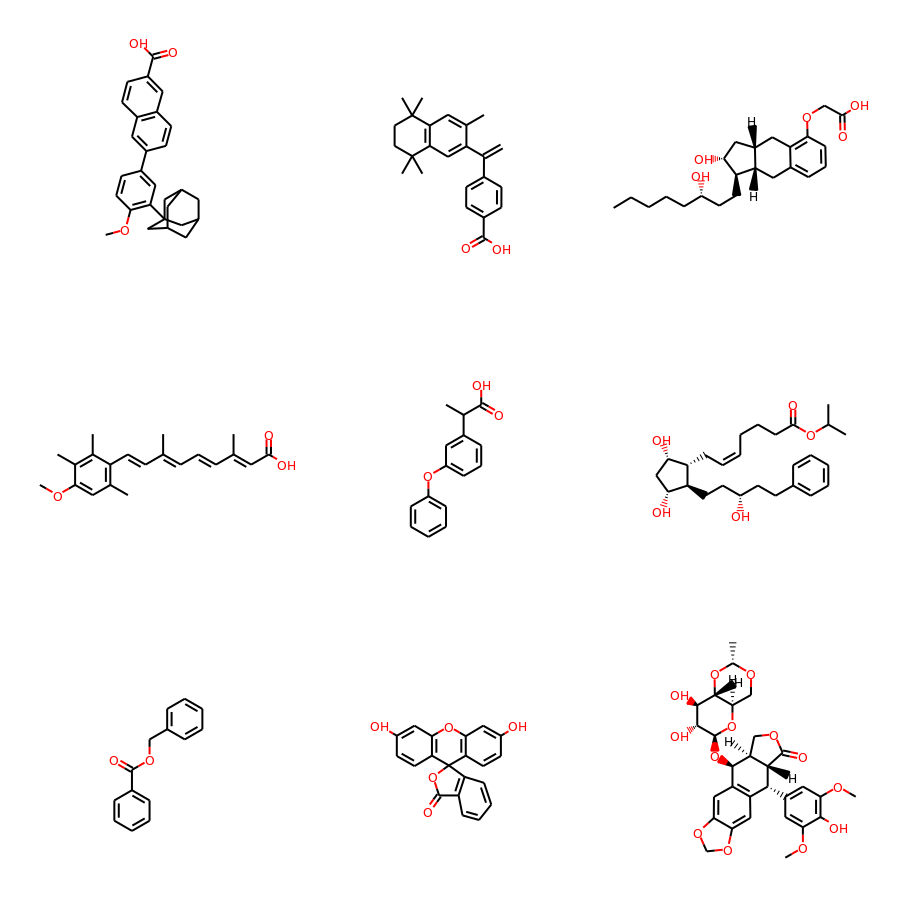

In [70]:
Draw.MolsToGridImage([drugbank[i] for i in perfect_match_indexes[:9]], subImgSize=(300, 300))

Now the same query w\ salicylic a., now with MACCS:

In [71]:
salicylica_maccs = MACCSkeys.GenMACCSKeys(salicylica)
salicylica_maccs

In [73]:
from rdkit import DataStructs
salicylica_maccs_similarities = [DataStructs.FingerprintSimilarity(salicylica_maccs, mol_fp) for mol_fp in maccs_fps]
len(salicylica_maccs_similarities), min(salicylica_maccs_similarities), max(salicylica_maccs_similarities)

(7110, 0.0, 1.0)

In [75]:
perfect_match_indexes = [i for i, similarity in enumerate(salicylica_maccs_similarities) if similarity == 1]
perfect_match_indexes

[815]

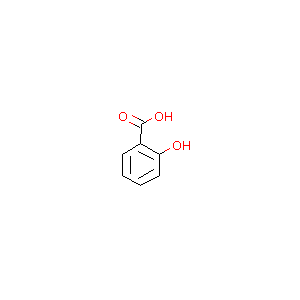

In [76]:
Draw.MolToImage(drugbank[815])

TODO: top 9 matches w\ written similarity

TODO: hashed fingerprints